In [ ]:
#Google slide summarizing main results
https://docs.google.com/presentation/d/1ca-1lmofn88hM-9Fp8JztW8X1mzlgOsGtXUh_dgZPgk/edit?usp=sharing

In [1]:
import pandas as pd
import math
import numpy as np
from mnist.loader import MNIST
import pandas as pd

In [2]:
def findRegParms(numTimePts,numHidNodes,fileName):
    numEdges = numHidNodes*(numHidNodes-1)
    x = np.empty(numTimePts)
    y = np.empty([numTimePts*numEdges,1])
    for i in range(0,numTimePts):
        x[i]=(i/10)

    with open("C:/Users/Joseph Hwang/Desktop/Sample_Output_Practice/Sample_Output_4/" + fileName) as infile:
    #with open("C:/Users/Joseph Hwang/Desktop/Sample_Output_Practice/Sample_Output_1/" + fileName) as infile:
        i = 0
        for line in infile:
            # print(line.split(" ")[16])
            #y[i]= line.split(" ")[16]
            y[i]= line.split(" ")[0]
            #y[int(floor(i)][i%numEdges]
            i = i + 1
        y = y.reshape((numTimePts, numEdges))
    m, b = np.polyfit(x, y, 1)
    return m,b,y[3]

In [3]:
numTimePts = 21 # number of time points
numHidNodes = 100 # number of hidden nodes
numExamples = 10000 # number of instances you want to process

edge_names = []
for i in range(784,(784+numHidNodes)):
    for j in range((784+numHidNodes-1),783,-1):
        if(i!=j):
            edge_names.append(str(i)+'_'+str(j))

slope_vals = np.empty([numExamples,len(edge_names)])
intercept_vals = np.empty([numExamples,len(edge_names)])
edge_vals = np.empty([numExamples,len(edge_names)])

for i in range(numExamples):
    #fileName = "temp." + str(i) + ".out"
    fileName = str(i) + ".out"
    slopes, intercepts, edgeWeights = findRegParms(numTimePts,numHidNodes,fileName)
    slope_vals[i]=slopes
    intercept_vals[i]=intercepts
    edge_vals[i]=edgeWeights
    

In [4]:
df_slopes = pd.DataFrame(list(slope_vals),columns=edge_names)
df_intercepts = pd.DataFrame(list(intercept_vals),columns=edge_names)
df_edgeWeights = pd.DataFrame(list(edge_vals),columns=edge_names)
#df_combined = pd.concat([df_slopes, df_intercepts], axis=1, join = 'inner')

In [5]:
mnist_input_data_path = "C:/Users/Joseph Hwang/Desktop/MNIST/MNIST_data"
mndata = MNIST(mnist_input_data_path)
train_images, train_labels = mndata.load_training()

In [6]:
from sklearn.preprocessing import Binarizer
binarizer = Binarizer()
binarized_train_images = binarizer.transform(train_images)

In [7]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)

In [8]:
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(8, 6), dpi=80)
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            #imagebox = offsetbox.AnnotationBbox(
                #offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                #X[i])
            #ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    
    if title is not None:
        plt.title(title)

In [9]:
def runLDA(X, y, c):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10)
    
    X2 = X_train.copy()
    X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible
    t0 = time()
    X_ldaFit = discriminant_analysis.LinearDiscriminantAnalysis(n_components=c
                                                         ).fit(X2, y_train)
    X_trained_ldaFit = X_ldaFit.transform(X2)
    #plot_embedding(X_ldaFit,
     #              "Linear Discriminant projection of the digits (time %.2fs)" %
      #             (time() - t0))
    #plot_embedding(X_trained_ldaFit,
     #              "Linear Discriminant projection of the digits (time %.2fs)" %
      #             (time() - t0))
    
    X2 = X_test.copy()
    X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible
    t0 = time()
    X_test_ldaFit = X_ldaFit.transform(X2)
    return X_trained_ldaFit, X_test_ldaFit, y_train, y_test
    

In [10]:
def runTSNE(X, y, c):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10)

    tsne = manifold.TSNE(n_components=c, init='pca', random_state=0)
    t0 = time()
    X_trained_tsne = tsne.fit_transform(X_train)
    X_test_tsne = tsne.fit_transform(X_test)
    return X_trained_tsne, X_test_tsne, y_train, y_test

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [11]:
def findKNN(X_train, X_test, y_train, y_test):
    #from sklearn.model_selection import train_test_split
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10)

    from sklearn.neighbors import KNeighborsClassifier
    #classifier = KNeighborsClassifier(n_neighbors = 5)
    classifier = KNeighborsClassifier(weights="distance", n_neighbors = 5)

    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)

    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    #result = confusion_matrix(y_test, y_pred)
    #print("Confusion Matrix:")
    #print(result)
    result1 = classification_report(y_test, y_pred)
    print("Classification Report:",)
    print (result1)
    result2 = accuracy_score(y_test,y_pred)
    print("Accuracy:",result2)
    return result2

In [75]:
#Edge Space
KNN_scores_edge = []
for x in range(10):
    for y in range(1,10):        
        X_train1, X_test1, y_train1, y_test1 = runLDA(df_edgeWeights.iloc[:].values, train_labels[:numExamples], y)
        KNN_scores_edge.append(findKNN(X_train1, X_test1, y_train1, y_test1))

Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.27      0.25       103
           1       0.18      0.24      0.20        92
           2       0.26      0.21      0.24       112
           3       0.15      0.16      0.16       102
           4       0.16      0.18      0.17        91
           5       0.13      0.09      0.11        98
           6       0.38      0.46      0.41        85
           7       0.23      0.20      0.21       112
           8       0.09      0.09      0.09       103
           9       0.19      0.17      0.18       102

    accuracy                           0.20      1000
   macro avg       0.20      0.21      0.20      1000
weighted avg       0.20      0.20      0.20      1000

Accuracy: 0.202
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.74      0.71        94
           1       0.72      0.81      0.76       113
           2    

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       102
           1       0.81      0.92      0.86       118
           2       0.35      0.29      0.32       100
           3       0.19      0.18      0.18       101
           4       0.38      0.39      0.38        97
           5       0.28      0.33      0.31        87
           6       0.23      0.23      0.23       105
           7       0.44      0.38      0.41       108
           8       0.40      0.34      0.37       100
           9       0.30      0.34      0.32        82

    accuracy                           0.43      1000
   macro avg       0.41      0.42      0.41      1000
weighted avg       0.42      0.43      0.42      1000

Accuracy: 0.43
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84        92
           1       0.78      0.90      0.84       117
           2     

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86       103
           1       0.82      0.91      0.86       117
           2       0.67      0.64      0.66       107
           3       0.50      0.61      0.55        77
           4       0.47      0.45      0.46       105
           5       0.44      0.42      0.43        91
           6       0.66      0.84      0.74       101
           7       0.71      0.64      0.67       111
           8       0.34      0.26      0.29        93
           9       0.35      0.35      0.35        95

    accuracy                           0.61      1000
   macro avg       0.59      0.59      0.59      1000
weighted avg       0.60      0.61      0.60      1000

Accuracy: 0.606
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       105
           1       0.87      0.87      0.87       105
           2    

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84        93
           1       0.86      0.95      0.90       116
           2       0.57      0.56      0.57        80
           3       0.66      0.61      0.63       104
           4       0.54      0.54      0.54       101
           5       0.67      0.64      0.66        89
           6       0.65      0.83      0.73       103
           7       0.82      0.75      0.79       106
           8       0.66      0.52      0.58       103
           9       0.56      0.56      0.56       105

    accuracy                           0.69      1000
   macro avg       0.68      0.68      0.68      1000
weighted avg       0.69      0.69      0.68      1000

Accuracy: 0.687
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83        90
           1       0.81      0.87      0.84       105
           2    

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       107
           1       0.83      0.89      0.86       124
           2       0.77      0.76      0.76        96
           3       0.65      0.65      0.65        85
           4       0.59      0.66      0.62        87
           5       0.54      0.61      0.57        75
           6       0.82      0.80      0.81       111
           7       0.77      0.79      0.78       109
           8       0.69      0.64      0.67        92
           9       0.66      0.60      0.63       114

    accuracy                           0.73      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.73      0.73      0.73      1000

Accuracy: 0.729
Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.33      0.29        96
           1       0.34      0.33      0.34       117
           2    

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.75      0.69        89
           1       0.77      0.90      0.83       106
           2       0.19      0.17      0.18       100
           3       0.36      0.42      0.39       104
           4       0.31      0.37      0.34        83
           5       0.22      0.16      0.18        90
           6       0.33      0.28      0.31       123
           7       0.34      0.31      0.32       127
           8       0.21      0.16      0.19        91
           9       0.18      0.21      0.19        87

    accuracy                           0.38      1000
   macro avg       0.35      0.37      0.36      1000
weighted avg       0.36      0.38      0.36      1000

Accuracy: 0.375
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.74      0.77        97
           1       0.86      0.90      0.88       113
           2    

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.79      0.76        92
           1       0.88      0.89      0.88       120
           2       0.71      0.60      0.65       106
           3       0.57      0.63      0.60       107
           4       0.46      0.52      0.49       106
           5       0.27      0.28      0.28        86
           6       0.73      0.83      0.78       105
           7       0.55      0.60      0.57        98
           8       0.32      0.22      0.26        89
           9       0.42      0.34      0.38        91

    accuracy                           0.59      1000
   macro avg       0.56      0.57      0.56      1000
weighted avg       0.58      0.59      0.58      1000

Accuracy: 0.587
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.81      0.86       108
           1       0.80      0.90      0.84        97
           2    

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       138
           1       0.80      0.93      0.86       101
           2       0.56      0.58      0.57       100
           3       0.51      0.42      0.46       104
           4       0.61      0.65      0.63        92
           5       0.36      0.27      0.31        92
           6       0.71      0.80      0.75        84
           7       0.66      0.62      0.64       102
           8       0.29      0.33      0.31        92
           9       0.47      0.47      0.47        95

    accuracy                           0.61      1000
   macro avg       0.59      0.59      0.59      1000
weighted avg       0.60      0.61      0.60      1000

Accuracy: 0.606
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.77      0.82        99
           1       0.85      0.91      0.88       113
           2    

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89        94
           1       0.80      0.89      0.84       105
           2       0.74      0.68      0.70       111
           3       0.67      0.61      0.64       105
           4       0.58      0.66      0.61        99
           5       0.46      0.43      0.45        76
           6       0.81      0.80      0.80       122
           7       0.77      0.65      0.70       105
           8       0.61      0.71      0.66        92
           9       0.46      0.45      0.45        91

    accuracy                           0.69      1000
   macro avg       0.68      0.68      0.68      1000
weighted avg       0.69      0.69      0.69      1000

Accuracy: 0.687
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       108
           1       0.88      0.88      0.88       120
           2    

In [107]:
data = KNN_scores_feature
new_data = [data[x:x+9] for x in range(0, len(data), 9)]
#print(new_data)
df_KNN_feature = pd.DataFrame([])
for x in range(10):
    df_KNN_feature.insert(loc=x, column="Trial " + str(x), value=new_data[x])
    
print(df_KNN_feature)

   Trial 0  Trial 1  Trial 2  Trial 3  Trial 4  Trial 5  Trial 6  Trial 7  \
0    0.284    0.297    0.298    0.329    0.280    0.321    0.287    0.310   
1    0.558    0.563    0.597    0.548    0.576    0.563    0.574    0.542   
2    0.679    0.677    0.656    0.662    0.679    0.714    0.662    0.668   
3    0.784    0.768    0.788    0.783    0.781    0.753    0.790    0.781   
4    0.793    0.794    0.799    0.796    0.789    0.796    0.794    0.805   
5    0.811    0.822    0.815    0.830    0.828    0.819    0.828    0.830   
6    0.878    0.857    0.876    0.875    0.870    0.890    0.866    0.873   
7    0.876    0.888    0.878    0.876    0.858    0.878    0.876    0.879   
8    0.878    0.905    0.878    0.890    0.888    0.884    0.892    0.880   

   Trial 8  Trial 9  
0    0.294    0.301  
1    0.554    0.553  
2    0.686    0.666  
3    0.781    0.757  
4    0.819    0.793  
5    0.850    0.818  
6    0.886    0.870  
7    0.904    0.876  
8    0.900    0.882  


In [ ]:
#Feature space
KNN_scores_feature = []
for x in range(10):
    for y in range(1,10):        
        X_train3, X_test3, y_train3, y_test3 = runLDA(binarized_train_images[:10000].astype(float), train_labels[:numExamples], y)
        KNN_scores_feature.append(findKNN(X_train3, X_test3, y_train3, y_test3))

In [13]:
#Edge Space
X_train1, X_test1, y_train1, y_test1 = runLDA(df_edgeWeights.iloc[:].values, train_labels[:numExamples], 2)
findKNN(X_train1, X_test1, y_train1, y_test1)

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.79      0.76       100
           1       0.74      0.78      0.76       100
           2       0.20      0.20      0.20       102
           3       0.20      0.17      0.18       106
           4       0.28      0.30      0.29        90
           5       0.12      0.10      0.11        93
           6       0.30      0.42      0.35       102
           7       0.40      0.42      0.41        98
           8       0.13      0.13      0.13       100
           9       0.30      0.23      0.26       109

    accuracy                           0.35      1000
   macro avg       0.34      0.35      0.34      1000
weighted avg       0.34      0.35      0.34      1000

Accuracy: 0.353


0.353

In [12]:
#Slope Space
X_train2, X_test2, y_train2, y_test2 = runLDA(df_slopes.iloc[:].values, train_labels[:numExamples], 2)
findKNN(X_train2, X_test2, y_train2, y_test2)

Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.45      0.31       112
           1       0.30      0.46      0.36       114
           2       0.15      0.04      0.06       108
           3       0.13      0.15      0.14       103
           4       0.10      0.15      0.12       103
           5       0.07      0.06      0.07        84
           6       0.05      0.02      0.03       101
           7       0.09      0.15      0.11        89
           8       0.21      0.05      0.08       107
           9       0.15      0.08      0.10        79

    accuracy                           0.17      1000
   macro avg       0.15      0.16      0.14      1000
weighted avg       0.15      0.17      0.14      1000

Accuracy: 0.167


0.167

In [15]:
#Feature Space
X_train3, X_test3, y_train3, y_test3 = runLDA(binarized_train_images[:10000].astype(float), train_labels[:numExamples], 2)
findKNN(X_train3, X_test3, y_train3, y_test3)

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.86       111
           1       0.74      0.79      0.76       109
           2       0.32      0.32      0.32        96
           3       0.31      0.32      0.32        99
           4       0.54      0.65      0.59        88
           5       0.33      0.27      0.29       104
           6       0.78      0.67      0.72       109
           7       0.66      0.66      0.66       108
           8       0.28      0.30      0.29        90
           9       0.45      0.48      0.46        86

    accuracy                           0.54      1000
   macro avg       0.53      0.53      0.53      1000
weighted avg       0.54      0.54      0.54      1000

Accuracy: 0.538


0.538

In [45]:
X = edge_vals
y = train_labels[:numExamples]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10)

from sklearn.neighbors import KNeighborsClassifier
#classifier = KNeighborsClassifier(n_neighbors = 5)
classifier = KNeighborsClassifier(weights="distance", metric="manhattan", n_neighbors = 5)
#metric="manhattan"
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#result = confusion_matrix(y_test, y_pred)
#print("Confusion Matrix:")
#print(result)
result1 = classification_report(y_test, y_pred)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test,y_pred)
print("Accuracy:",result2)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       113
           1       0.90      0.99      0.95       114
           2       1.00      0.92      0.96        90
           3       0.95      0.94      0.95       111
           4       0.98      0.90      0.94       114
           5       0.92      0.89      0.91        75
           6       0.97      0.95      0.96       104
           7       0.94      0.98      0.96       106
           8       0.92      0.88      0.90        81
           9       0.90      0.95      0.92        92

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000

Accuracy: 0.942


In [19]:
X_train3, X_test3, y_train3, y_test3 = runTSNE(binarized_train_images[:10000].astype(float), train_labels[:numExamples], 3)
findKNN(X_train3, X_test3, y_train3, y_test3)

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.66      0.74       101
           1       0.25      0.01      0.02       101
           2       0.00      0.00      0.00       122
           3       0.04      0.07      0.05        89
           4       0.06      0.05      0.06        95
           5       0.03      0.07      0.05        70
           6       0.00      0.00      0.00       108
           7       0.38      0.53      0.44       104
           8       0.15      0.35      0.21       108
           9       0.37      0.35      0.36       102

    accuracy                           0.21      1000
   macro avg       0.21      0.21      0.19      1000
weighted avg       0.21      0.21      0.19      1000

Accuracy: 0.213


Computing Linear Discriminant Analysis projection


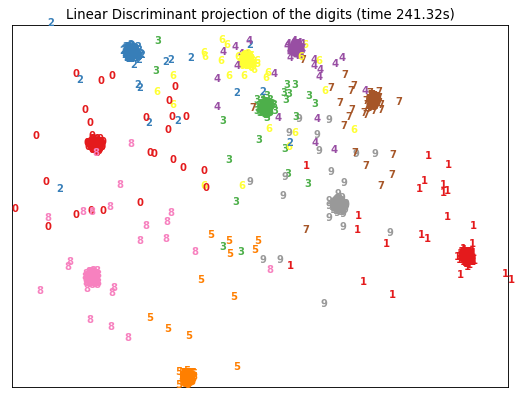

In [36]:
X = np.array(df_edgeWeights)
y = train_labels[:10000]

print("Computing Linear Discriminant Analysis projection")
X2 = X.copy()
X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible
t0 = time()
X_lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2
                                                         ).fit_transform(X2, y)
plot_embedding(X_lda,
               "Linear Discriminant projection of the digits (time %.2fs)" %
               (time() - t0))

Computing Linear Discriminant Analysis projection


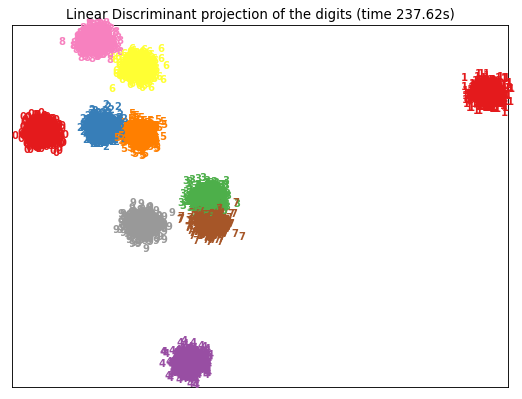

In [18]:
X = np.array(df_slopes)
y = train_labels[:10000]

print("Computing Linear Discriminant Analysis projection")
X2 = X.copy()
X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible
t0 = time()
X_lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2
                                                         ).fit_transform(X2, y)
plot_embedding(X_lda,
               "Linear Discriminant projection of the digits (time %.2fs)" %
               (time() - t0))

Computing Linear Discriminant Analysis projection


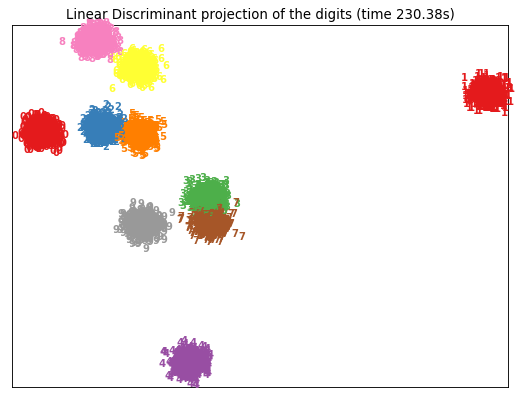

In [19]:
X = np.array(df_slopes)
y = train_labels[:10000]

print("Computing Linear Discriminant Analysis projection")
X2 = X.copy()
X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible
t0 = time()
X_lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2
                                                         ).fit_transform(X2, y)
plot_embedding(X_lda,
               "Linear Discriminant projection of the digits (time %.2fs)" %
               (time() - t0))

Computing Linear Discriminant Analysis projection


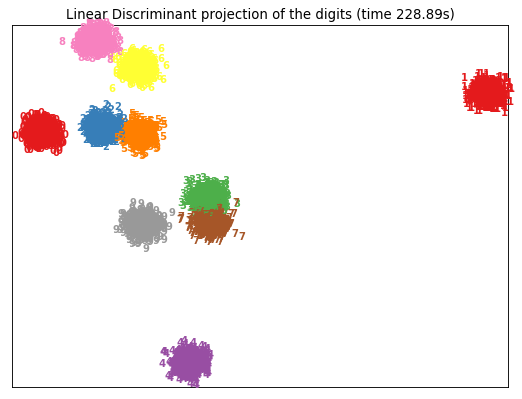

In [20]:
X = np.array(df_slopes)
y = train_labels[:10000]

print("Computing Linear Discriminant Analysis projection")
X2 = X.copy()
X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible
t0 = time()
X_lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2
                                                         ).fit_transform(X2, y)
plot_embedding(X_lda,
               "Linear Discriminant projection of the digits (time %.2fs)" %
               (time() - t0))

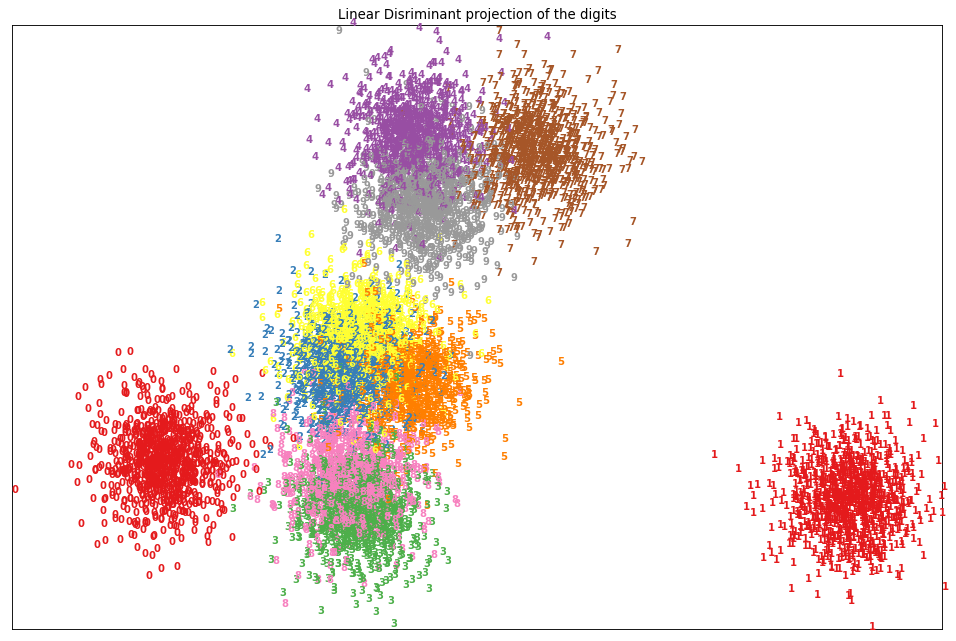

In [14]:
X1 = X_train2
X2 = X_test2
y1 = y_train2
y2 = y_test2
title = "Linear Disriminant projection of the digits"

x_min, x_max = np.min(X1, 0), np.max(X1, 0)
X1 = (X1 - x_min) / (x_max - x_min)

plt.figure(figsize=(15, 10), dpi=80)
ax = plt.subplot(111)
for i in range(X1.shape[0]):
    plt.text(X1[i, 0], X1[i, 1], str(y1[i]),
             color=plt.cm.Set1(y1[i] / 10.),
             #color="k",
             fontdict={'weight': 'bold', 'size': 9})
plt.xticks([]), plt.yticks([])

if title is not None:
    plt.title(title)

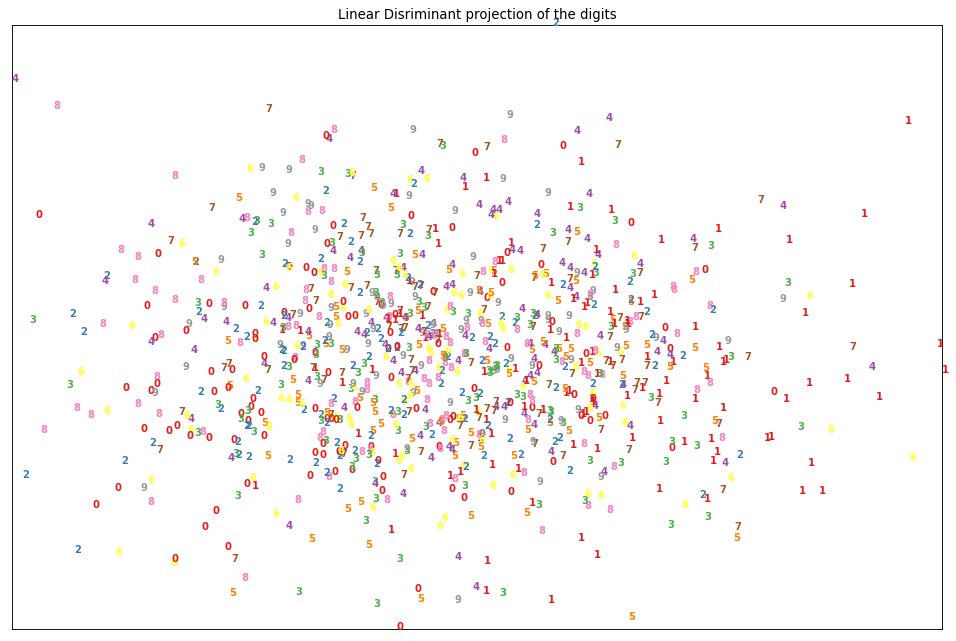

In [15]:
X1 = X_train2
X2 = X_test2
y1 = y_train2
y2 = y_test2
title = "Linear Disriminant projection of the digits"

x_min, x_max = np.min(X2, 0), np.max(X2, 0)
X2 = (X2 - x_min) / (x_max - x_min)

plt.figure(figsize=(15, 10), dpi=80)
ax = plt.subplot(111)
for i in range(X2.shape[0]):
    plt.text(X2[i, 0], X2[i, 1], str(y2[i]),
             color=plt.cm.Set1(y2[i] / 10.),
             #color="k",
             fontdict={'weight': 'bold', 'size':9})
plt.xticks([]), plt.yticks([])

if title is not None:
    plt.title(title)

<Figure size 1080x720 with 0 Axes>

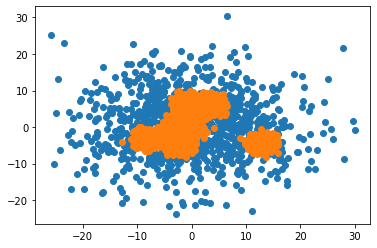

<Figure size 1080x720 with 0 Axes>

In [16]:
X1_value = X_train2[:, 0]
Y1_value = X_train2[:, 1]
X2_value = X_test2[:, 0]
Y2_value = X_test2[:, 1]
plt.scatter(X2_value, Y2_value)
plt.scatter(X1_value, Y1_value)
plt.figure(figsize=(15,10))

Computing Linear Discriminant Analysis projection


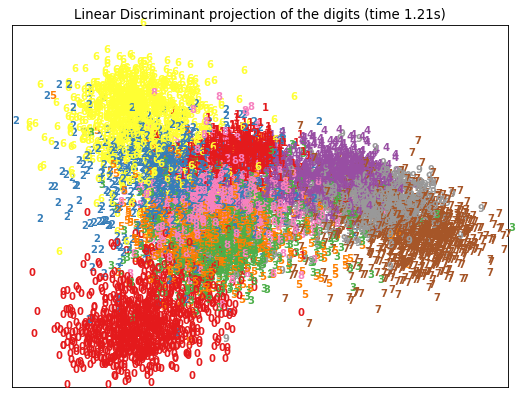

In [22]:
X = np.array(binarized_train_images[:10000].astype(float))
y = train_labels[:10000]

print("Computing Linear Discriminant Analysis projection")
X2 = X.copy()
X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible
t0 = time()
X_lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2
                                                         ).fit_transform(X2, y)
plot_embedding(X_lda,
               "Linear Discriminant projection of the digits (time %.2fs)" %
               (time() - t0))

Computing PCA projection


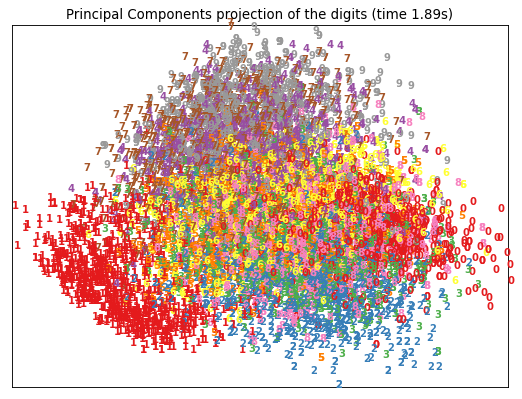

In [23]:
X = np.array(df_edgeWeights)
y = train_labels[:10000]

print("Computing PCA projection")
t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=3).fit_transform(X)
plot_embedding(X_pca[:,1:],
               "Principal Components projection of the digits (time %.2fs)" %
               (time() - t0))

Computing Spectral embedding


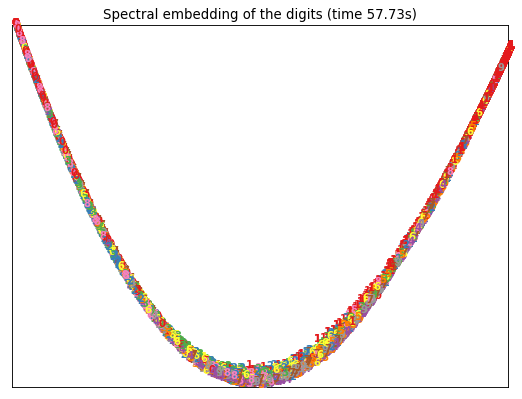

In [24]:
X = np.array(df_edgeWeights)
y = train_labels[:10000]

print("Computing Spectral embedding")
embedder = manifold.SpectralEmbedding(n_components=2, random_state=0,
                                      eigen_solver="arpack")
t0 = time()
X_se = embedder.fit_transform(X)

plot_embedding(X_se,
               "Spectral embedding of the digits (time %.2fs)" %
               (time() - t0))

Computing Isomap projection
Done.


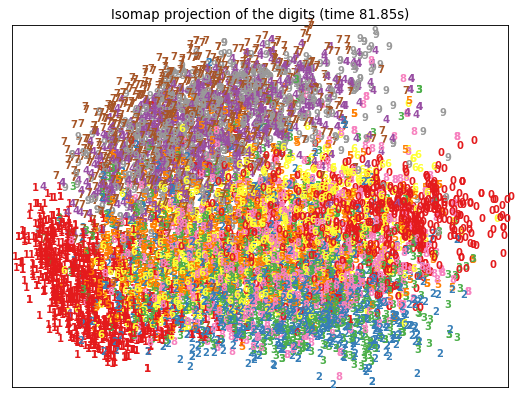

In [25]:
X = np.array(df_edgeWeights)
y = train_labels[:10000]

n_neighbors = 30

print("Computing Isomap projection")
t0 = time()
X_iso = manifold.Isomap(n_neighbors=n_neighbors, n_components=2
                        ).fit_transform(X)
print("Done.")
plot_embedding(X_iso,
               "Isomap projection of the digits (time %.2fs)" %
               (time() - t0))

Computing Isomap projection
Done.


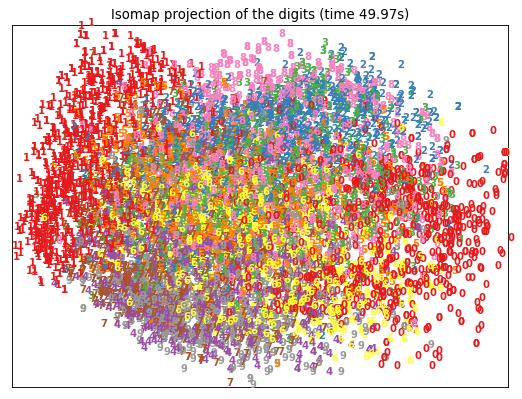

In [26]:
X = np.array(df_edgeWeights)
y = train_labels[:10000]

n_neighbors = 5

print("Computing Isomap projection")
t0 = time()
X_iso = manifold.Isomap(n_neighbors=n_neighbors, n_components=2
                        ).fit_transform(X)
print("Done.")
plot_embedding(X_iso,
               "Isomap projection of the digits (time %.2fs)" %
               (time() - t0))

Computing Isomap projection
Done.


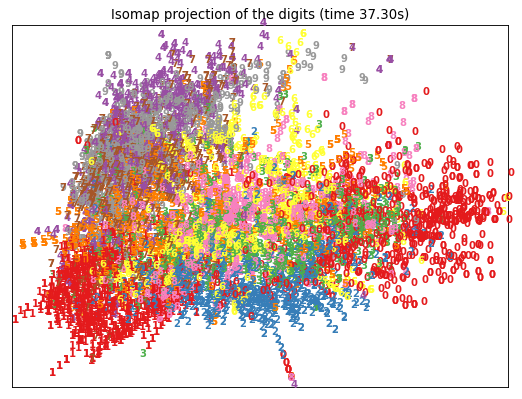

In [27]:
X = np.array(df_edgeWeights)
y = train_labels[:10000]

n_neighbors = 2

print("Computing Isomap projection")
t0 = time()
X_iso = manifold.Isomap(n_neighbors=n_neighbors, n_components=2
                        ).fit_transform(X)
print("Done.")
plot_embedding(X_iso,
               "Isomap projection of the digits (time %.2fs)" %
               (time() - t0))

Computing Isomap projection
Done.


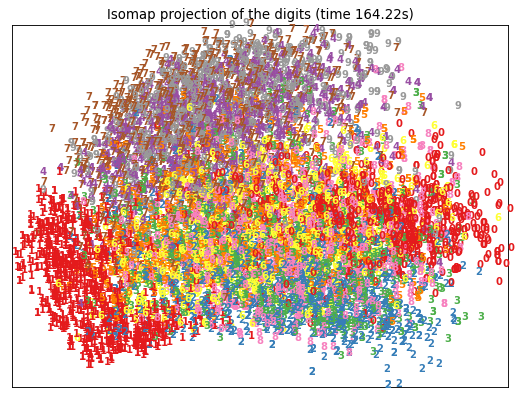

In [28]:
X = np.array(df_edgeWeights)
y = train_labels[:10000]

n_neighbors = 100

print("Computing Isomap projection")
t0 = time()
X_iso = manifold.Isomap(n_neighbors=n_neighbors, n_components=2
                        ).fit_transform(X)
print("Done.")
plot_embedding(X_iso,
               "Isomap projection of the digits (time %.2fs)" %
               (time() - t0))

Computing t-SNE embedding


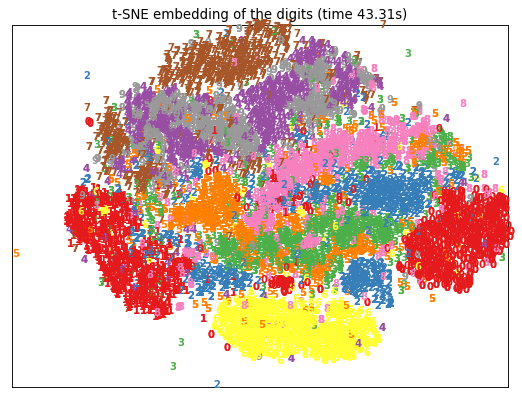

In [29]:
X = np.array(df_edgeWeights)
y = train_labels[:10000]

print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

Computing LLE embedding
Done. Reconstruction error: 0.000373973


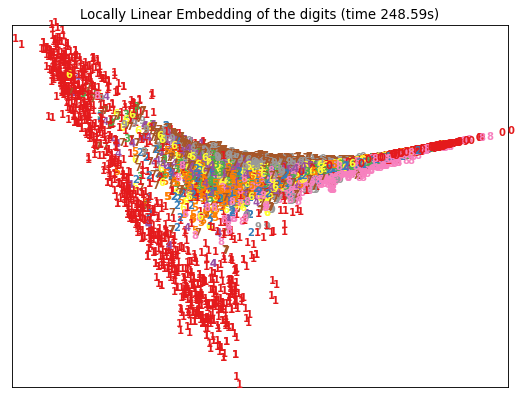

In [30]:
X = np.array(df_edgeWeights)
y = train_labels[:10000]

# Locally linear embedding of the digits dataset
print("Computing LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2,
                                      method='standard')
t0 = time()
X_lle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_lle,
               "Locally Linear Embedding of the digits (time %.2fs)" %
               (time() - t0))

Computing modified LLE embedding
Done. Reconstruction error: 3.31062


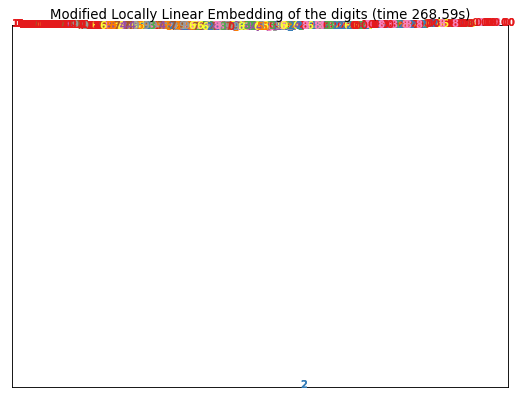

In [31]:
X = np.array(df_edgeWeights)
y = train_labels[:10000]

print("Computing modified LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2,
                                      method='modified')
t0 = time()
X_mlle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_mlle,
               "Modified Locally Linear Embedding of the digits (time %.2fs)" %
               (time() - t0))


Computing MDS embedding
Done. Stress: 39.049785


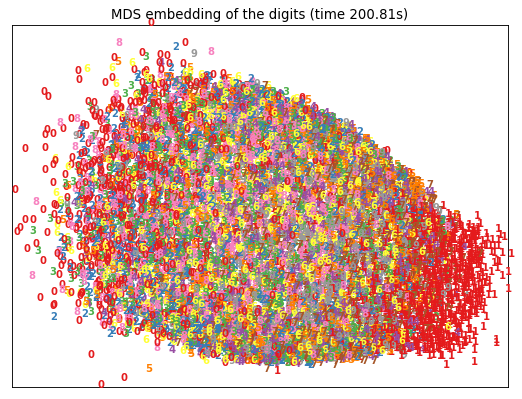

In [32]:
X = np.array(df_edgeWeights)
y = train_labels[:10000]

print("Computing MDS embedding")
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100)
t0 = time()
X_mds = clf.fit_transform(X)
print("Done. Stress: %f" % clf.stress_)
plot_embedding(X_mds,
               "MDS embedding of the digits (time %.2fs)" %
               (time() - t0))

Computing Totally Random Trees embedding


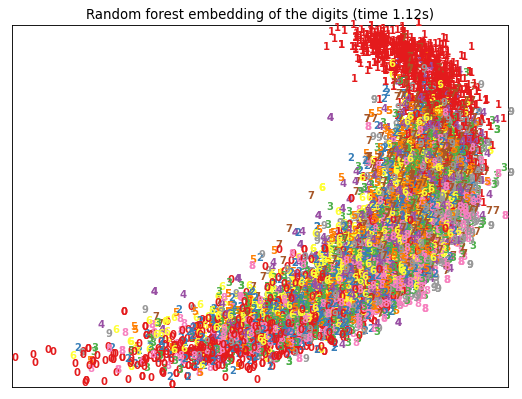

In [33]:
X = np.array(df_edgeWeights)
y = train_labels[:10000]

print("Computing Totally Random Trees embedding")
hasher = ensemble.RandomTreesEmbedding(n_estimators=200, random_state=0,
                                       max_depth=5)
t0 = time()
X_transformed = hasher.fit_transform(X)
pca = decomposition.TruncatedSVD(n_components=2)
X_reduced = pca.fit_transform(X_transformed)

plot_embedding(X_reduced,
               "Random forest embedding of the digits (time %.2fs)" %
               (time() - t0))

Computing t-SNE embedding


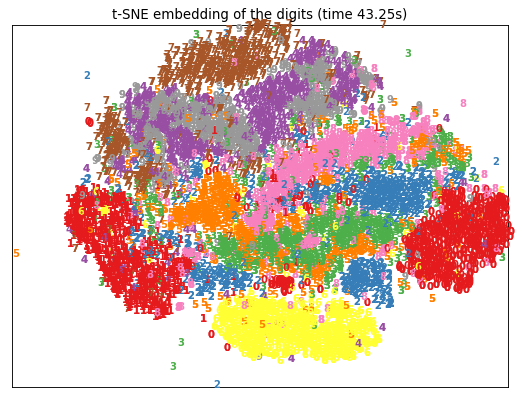

In [34]:
X = np.array(df_edgeWeights)
y = train_labels[:10000]

print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

Computing NCA projection


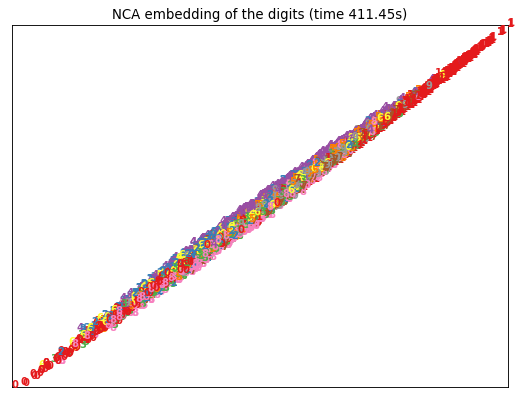

In [35]:
X = np.array(df_edgeWeights)
y = train_labels[:10000]

print("Computing NCA projection")
nca = neighbors.NeighborhoodComponentsAnalysis(init='random',
                                               n_components=2, random_state=0)
t0 = time()
X_nca = nca.fit_transform(X, y)

plot_embedding(X_nca,
               "NCA embedding of the digits (time %.2fs)" %
               (time() - t0))

In [36]:
X = binarized_train_images[:10000].astype(float)
y = train_labels[:numExamples]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10)

from sklearn.neighbors import KNeighborsClassifier
#classifier = KNeighborsClassifier(n_neighbors = 5)
classifier = KNeighborsClassifier(weights="distance", n_neighbors = 5)

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#result = confusion_matrix(y_test, y_pred)
#print("Confusion Matrix:")
#print(result)
result1 = classification_report(y_test, y_pred)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test,y_pred)
print("Accuracy:",result2)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        96
           1       0.92      0.98      0.95       116
           2       0.96      0.94      0.95       101
           3       0.96      0.95      0.95        97
           4       0.98      0.91      0.94       100
           5       0.95      0.86      0.90        88
           6       0.94      0.99      0.97       104
           7       0.98      0.98      0.98       112
           8       0.93      0.89      0.91        95
           9       0.87      0.95      0.91        91

    accuracy                           0.95      1000
   macro avg       0.95      0.94      0.95      1000
weighted avg       0.95      0.95      0.95      1000

Accuracy: 0.947
